# What do I want?

- Match COSMOS galaxies to HSC objects 
- Remove non-matched HSC objects
- Create a classification based on COSMOS features
    - (z < 0.15) and ($10^8$ < M_stellar < $10^9$ M$_\odot$)
- Use that COSMOS classification to create an HSC training set
- Run Random Forest & Logistic Regression on that data set (pure HSC features! no COSMOS features)
- Create visual diagnostics

I'll test two basic classifiers: a RandomForest classifier and a Logistic Regression classifier. I'll try a very simplistic weak-learner: a straight i-band cut.

For my training data, I started by getting objects and labels from COSMOS. For input features, I then matched those COSMOS galaxies to their nearest HSC counterpart. I then used HSC i-band magnitude, along with HSC g-r, r-i, i-z, z-y colors.  Finally, I augment it with some HSC photo-z information (`FRANKEN-Z`).

In this notebook I'll look at the full decision curves for the classifiers, in hopes of better understanding my results.

# Code

In [1]:
# give access to importing dwarfz
import os, sys
dwarfz_package_dir = os.getcwd().split("dwarfz")[0]
if dwarfz_package_dir not in sys.path:
    sys.path.insert(0, dwarfz_package_dir)

import dwarfz
    
# back to regular import statements

%matplotlib inline
from matplotlib import pyplot as plt

import seaborn as sns
sns.set(context="poster", style="ticks", font_scale=1.4)

import numpy as np
import pandas as pd

from scipy.special import expit

import pathlib

In [2]:
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['figure.figsize'] = 2*np.array((8,6))
mpl.rcParams['figure.facecolor'] = "white"

In [3]:
COSMOS_filename = pathlib.Path(dwarfz.data_dir_default) / "COSMOS_reference.sqlite"
COSMOS = dwarfz.datasets.COSMOS(COSMOS_filename)

In [4]:
HSC_filename = pathlib.Path(dwarfz.data_dir_default) / "HSC_COSMOS_median_forced.sqlite3"
HSC = dwarfz.datasets.HSC(HSC_filename)

In [5]:
matches_filename = pathlib.Path(dwarfz.data_dir_default) / "matches.sqlite3"
matches_df = dwarfz.matching.Matches.load_from_filename(matches_filename)

In [6]:
combined = matches_df[matches_df.match].copy()
combined["ra"]       = COSMOS.df.loc[combined.index].ra
combined["dec"]      = COSMOS.df.loc[combined.index].dec
combined["photo_z"]  = COSMOS.df.loc[combined.index].photo_z
combined["log_mass"] = COSMOS.df.loc[combined.index].mass_med

photometry_cols = [
    "gcmodel_flux","gcmodel_flux_err","gcmodel_flux_flags", "gcmodel_mag",
    "rcmodel_flux","rcmodel_flux_err","rcmodel_flux_flags", "rcmodel_mag",
    "icmodel_flux","icmodel_flux_err","icmodel_flux_flags", "icmodel_mag",
    "zcmodel_flux","zcmodel_flux_err","zcmodel_flux_flags", "zcmodel_mag",
    "ycmodel_flux","ycmodel_flux_err","ycmodel_flux_flags", "ycmodel_mag",
]

for col in photometry_cols:
    combined[col] = HSC.df.loc[combined.catalog_2_ids][col].values

## Turn magnitudes into colors

In [7]:
combined["g_minus_r"] = combined.gcmodel_mag - combined.rcmodel_mag
combined["r_minus_i"] = combined.rcmodel_mag - combined.icmodel_mag
combined["i_minus_z"] = combined.icmodel_mag - combined.zcmodel_mag
combined["z_minus_y"] = combined.zcmodel_mag - combined.ycmodel_mag

## Filter out bad data

In [8]:
mask =    np.isfinite(combined["g_minus_r"]) & np.isfinite(combined["r_minus_i"]) \
        & np.isfinite(combined["i_minus_z"]) & np.isfinite(combined["z_minus_y"]) \
        & np.isfinite(combined["icmodel_mag"]) \
        & (~combined.gcmodel_flux_flags) & (~combined.rcmodel_flux_flags) \
        & (~combined.icmodel_flux_flags) & (~combined.zcmodel_flux_flags) \
        & (~combined.ycmodel_flux_flags)

combined = combined[mask]

## Get FRANKENZ photo-z's


In [9]:
df_frankenz = pd.read_sql_table("photo_z",
                                "sqlite:///{}".format(
                                    pathlib.Path(dwarfz.data_dir_default)
                                                 / "HSC_matched_to_FRANKENZ.sqlite"),
                                index_col="object_id")

df_frankenz.head()

,FRANKENZ_ids,photoz_best,photoz_risk_best
object_id,,,
43158034708430853,43158034708462402,3.39,0.410430
43158034708430859,43158034708462728,2.68,0.186912
43158034708430861,43158034708462729,2.57,0.565077
43158034708430866,43158034708438547,1.59,0.466111
43158034708430870,43158034708438694,2.37,0.363387


In [10]:
combined = combined.join(df_frankenz[["photoz_best", "photoz_risk_best"]],
                         on="catalog_2_ids")

# Create classification labels

In [11]:
low_z    = (combined.photo_z  < .15)
low_mass = (combined.log_mass > 8) & (combined.log_mass < 9)

In [12]:
combined["low_z_low_mass"] = (low_z & low_mass)
combined.low_z_low_mass.mean()

0.002185072976027315

In [13]:
combined.low_z_low_mass.sum()

727

In [14]:
combined.shape

(332712, 35)

# Build Classifiers

In [15]:
features = combined.loc[:,["g_minus_r", "r_minus_i", "i_minus_z", "z_minus_y",
                           "icmodel_mag",
                           "photoz_best",
                           "photoz_risk_best" # The risk of photoz_best being outside of the range z_true +- 0.15(1+z_true). It ranges from 0 (safe) to 1(risky)
                          ]]

target = combined.loc[:,["low_z_low_mass"]]

In [16]:
target.mean()

low_z_low_mass    0.002185
dtype: float64

In [17]:
COSMOS_field_area = 2 # sq. degree
N_COSMOS_total = HSC.df.shape[0]
N_COSMOS_good = combined.shape[0]

true_dwarf_density = target.sum().values[0] / COSMOS_field_area 
print("true dwarf density: {:.2f} / sq. deg.".format(true_dwarf_density))

true dwarf density: 363.50 / sq. deg.


## Partition training and testing sets

In [21]:
testing_fraction = .1
np.random.seed(0)
shuffled_indices = np.random.permutation(target.index.values)

N_testing_indices = int(testing_fraction*shuffled_indices.size)
testing_set_indices  = shuffled_indices[:N_testing_indices]
training_set_indices = shuffled_indices[N_testing_indices:]

features_train = features.loc[training_set_indices]
features_test  = features.loc[testing_set_indices]

target_train   = target.loc[training_set_indices]
target_test    = target.loc[testing_set_indices]

true_dwarf     =  target_test.values.flatten()
true_non_dwarf = ~target_test.values.flatten()

In [18]:
# def get_classification_characteristics(target_prob, threshold_prob, verbose=False):

#     target_prediction = (target_prob > threshold_prob)
    
#     prediction_dwarf     =  target_prediction
#     prediction_non_dwarf = ~target_prediction
    
#     completeness = (true_dwarf & prediction_dwarf).sum() / true_dwarf.sum() 
    
#     purity = (true_dwarf & prediction_dwarf).sum() / prediction_dwarf.sum() 
    
#     sample_size_reduction = prediction_dwarf.size / prediction_dwarf.sum()
    
#     true_positives  = np.sum(true_dwarf     & prediction_dwarf)
#     false_positives = np.sum(true_non_dwarf & prediction_dwarf)
    
#     true_negatives  = np.sum(true_non_dwarf & prediction_non_dwarf)
#     false_negatives = np.sum(true_dwarf     & prediction_non_dwarf)
    
#     true_positive_rate  = true_positives  / true_dwarf.sum()
#     false_positive_rate = false_positives / true_non_dwarf.sum()
    
#     objects_per_sq_deg = N_COSMOS_good / COSMOS_field_area / sample_size_reduction
    
#     if verbose:
#         print("completeness:          ", completeness)
#         print("purity:                ", purity)
#         print("sample_size_reduction: ", sample_size_reduction)
#         print("true  positive rate:   ", true_positive_rate)
#         print("false positive rate:   ", false_positive_rate)
#         print("objects per sq deg:    ", objects_per_sq_deg)
        
#     return {
#         "completeness": completeness,
#         "purity": purity,
#         "sample_size_reduction": sample_size_reduction,
#         "threshold_prob": threshold_prob,
#         "true_positive_rate": true_positive_rate,
#         "false_positive_rate": false_positive_rate,
#         "objects_per_sq_deg" : objects_per_sq_deg,
#            }

## Shared Plotting Parameters

In [22]:
color_RF = "g"
color_LR = "b"
color_MC = "r"

label_RF = "Random Forest"
label_LR = "Logistic Regression"
label_MC = "Magnitude Cut"

linewidth = 4

# Cross-validation Wrapper
**Note**: this doesn't perfectly handle when the number of objects doesn't evenly divide by the number of folds. In practice an example might be held out multiple times, and I'll just throw those few examples away.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


In [29]:
n_folds_default = 10
def get_cross_validation_matrix(classifier, seed=0, folds=n_folds_default, only_i_mag=False):
    
    np.random.seed(seed)
    testing_fraction = 1/folds

    shuffled_indices = np.random.permutation(target.index.values)
    all_indices_set = set(shuffled_indices)
    
    results = {HSC_id: []
               for HSC_id in combined.loc[shuffled_indices].catalog_2_ids.drop_duplicates().values}
    
    for fold in range(folds):
        print("\rfold: {} / {}".format(fold+1, folds), end="", flush=True)
        if fold == folds-1:
            testing_set_indices  = shuffled_indices[fold*N_testing_indices:]
        else:
            testing_set_indices  = shuffled_indices[fold*N_testing_indices:(fold+1)*N_testing_indices]

        training_set_indices = np.array(list(all_indices_set - set(testing_set_indices)))

        
        features_train = features.loc[training_set_indices]
        features_test  = features.loc[testing_set_indices]
        if only_i_mag:
            features_train = features_train[["icmodel_mag"]]
            features_test  = features_test[["icmodel_mag"]]


        target_train   = target.loc[training_set_indices]
        target_test    = target.loc[testing_set_indices]
        
        
        classifier.fit(features_train, target_train.values.flatten())
        target_prob = classifier.predict_proba(features_test)[:,1]
        
        
        for i, COSMOS_id in enumerate(testing_set_indices):
            HSC_id = combined.loc[COSMOS_id].catalog_2_ids
            results[HSC_id].append(target_prob[i])
        
    return results

## i-mag cut

In [30]:
classifier_i_mag = LogisticRegression(class_weight=None, 
                                      solver="lbfgs", 
                                      max_iter=300)

fold: 10 / 10

## Logistic Regression

In [32]:
classifier_LR = LogisticRegression(class_weight=None, 
                                   solver="lbfgs", 
                                   max_iter=300)

fold: 10 / 10

## Random Forest

In [33]:
classifier_RF = RandomForestClassifier(n_estimators=1000, 
                                       n_jobs=4)


fold: 10 / 10

## Save all model results
Note, I previously saved this data at `../data/galaxy_images_training/2017_09_26-dwarf_galaxy_scores.csv`. That's the version I use in constructing my DNN training set. The file created below isn't likely to be significantly better/different, but it uses different random seeds and thus will have some small variations in the probabilities assigned to each galaxy.

In [34]:
hdf_file = pathlib.Path("results_cross-validated_all.hdf5")
overwrite = False
if (not hdf_file.is_file()) or overwrite:
    results_RF = get_cross_validation_matrix(classifier_RF)
    results_LR = get_cross_validation_matrix(classifier_LR)
    results_i_mag = get_cross_validation_matrix(classifier_i_mag, 
                                                only_i_mag=True)

    HSC_ids = list(sorted(results_LR.keys()))

    HSC_ids = [HSC_id for HSC_id in HSC_ids
               if len(results_LR[HSC_id])==1]

    df_results = pd.DataFrame({
        "HSC_id":  HSC_ids,
        "LR_prob": [results_LR[HSC_id][0] for HSC_id in HSC_ids],
        "RF_prob": [results_RF[HSC_id][0] for HSC_id in HSC_ids],
        "i_mag_prob": [results_i_mag[HSC_id][0] for HSC_id in HSC_ids],
        "target": combined.set_index("catalog_2_ids").loc[HSC_ids].low_z_low_mass

    })

    df_results.to_hdf(hdf_file, key="results")
else:
    df_results = pd.read_hdf(hdf_file)
    
df_results.head()

,HSC_id,LR_prob,RF_prob,i_mag_prob,target
catalog_2_ids,,,,,
43158176442354198,43158176442354198,0.000259,0.0,0.000574,False
43158176442354210,43158176442354210,0.000655,0.0,0.000479,False
43158176442354213,43158176442354213,0.002109,0.0,0.000546,False
43158176442354230,43158176442354230,0.000326,0.0,0.000607,False
43158176442354240,43158176442354240,0.000597,0.0,0.001646,False


# Get Metrics from cross-validated results

In [35]:
threshold_probs = expit(np.linspace(-9, 6))
threshold_probs = np.array([-1e-6, *threshold_probs, 1+1e-6])

In [36]:
def get_purities(key, df_results=df_results, threshold_probs=threshold_probs):
    
    purities = np.empty_like(threshold_probs)
    df_tmp = df_results[[key, "target"]]
    
    for i, threshold_prob in enumerate(threshold_probs):
        mask = df_tmp[key] > threshold_prob
        purities[i] = df_tmp["target"][mask].mean()
    
    return purities

def get_completenesses(key, df_results=df_results, threshold_probs=threshold_probs):
    
    completenesses = np.empty_like(threshold_probs)
    df_tmp = df_results[[key, "target"]]
    df_tmp = df_tmp[df_tmp.target]

    for i, threshold_prob in enumerate(threshold_probs):
        mask = df_tmp[key] > threshold_prob

        completenesses[i] = mask.mean()
    
    return completenesses


def get_selected_object_density(key, df_results=df_results, threshold_probs=threshold_probs):
    """per sq deg"""
    object_density = np.empty_like(threshold_probs)
    df_tmp = df_results[[key, "target"]]

    for i, threshold_prob in enumerate(threshold_probs):
        mask = df_tmp[key] > threshold_prob

        object_density[i] = mask.sum()
    
    return object_density / COSMOS_field_area
    
    
def get_FPRs(key, df_results=df_results, threshold_probs=threshold_probs):
    
    FPRs = np.empty_like(threshold_probs)
    df_tmp = df_results[[key, "target"]]
    df_tmp = df_tmp[~df_tmp.target]

    for i, threshold_prob in enumerate(threshold_probs):
        mask = df_tmp[key] > threshold_prob

        FPRs[i] = mask.mean()
    
    return FPRs



In [37]:
purities_RF = get_purities("RF_prob")
completenesses_RF = get_completenesses("RF_prob")
TPR_RF = completenesses_RF
FPR_RF = get_FPRs("RF_prob")
object_density_RF = get_selected_object_density("RF_prob")


purities_LR = get_purities("LR_prob")
completenesses_LR = get_completenesses("LR_prob")
TPR_LR = completenesses_LR
FPR_LR = get_FPRs("LR_prob")
object_density_LR = get_selected_object_density("LR_prob")

purities_i_mag = get_purities("i_mag_prob")
completenesses_i_mag = get_completenesses("i_mag_prob")
TPR_i_mag = completenesses_i_mag
FPR_i_mag = get_FPRs("i_mag_prob")
object_density_i_mag = get_selected_object_density("i_mag_prob")

In [38]:
import sklearn
import sklearn.metrics

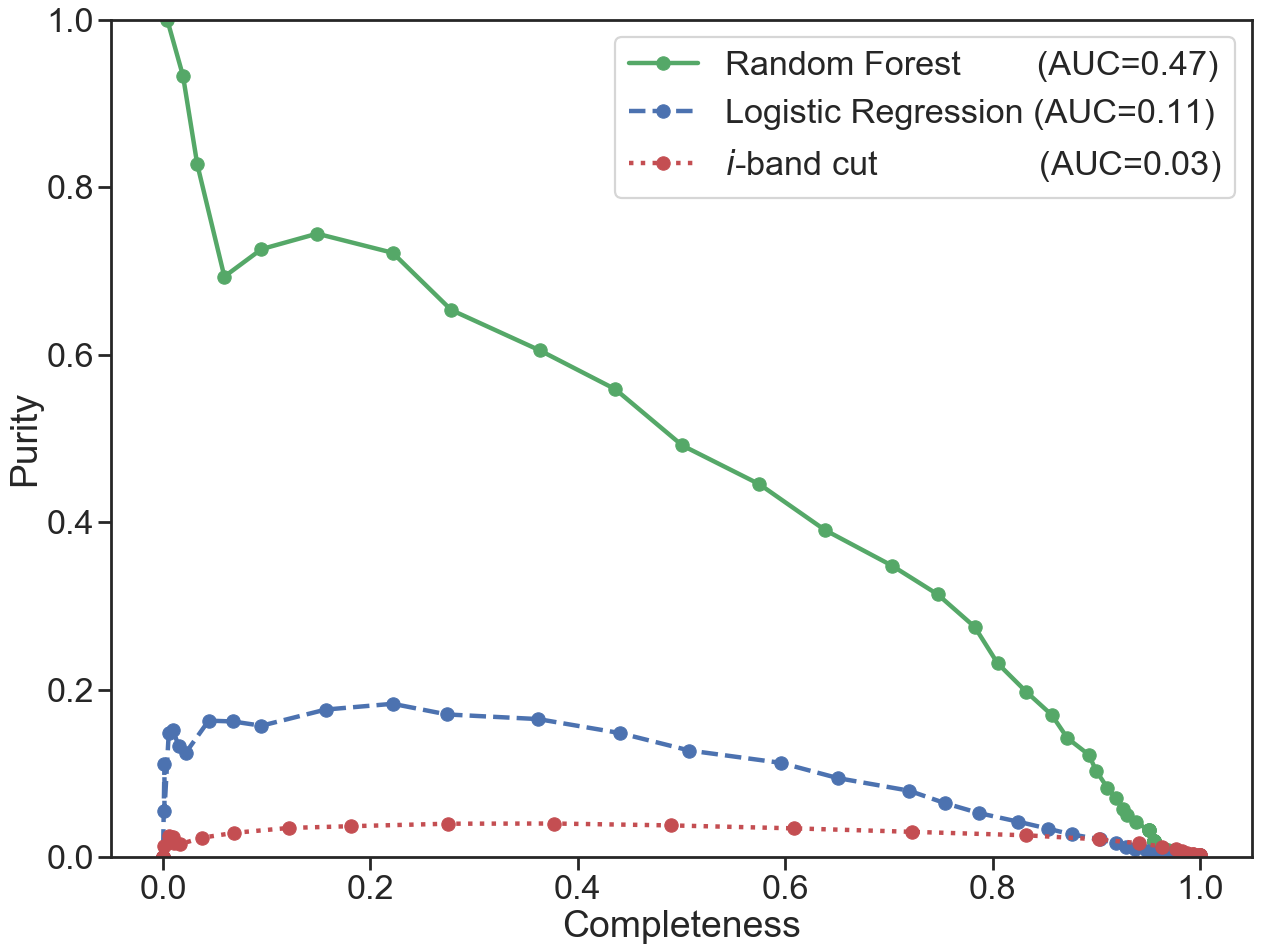

In [39]:
AUC_RF = sklearn.metrics.average_precision_score(df_results.target, df_results.RF_prob)
plt.plot(completenesses_RF, purities_RF,
         marker="o", color=color_RF, label="Random Forest        (AUC={:.2f})".format(AUC_RF), 
         linewidth=linewidth,
)

AUC_LR = sklearn.metrics.average_precision_score(df_results.target, df_results.LR_prob)
plt.plot(completenesses_LR, purities_LR,
         marker="o", color=color_LR, label="Logistic Regression (AUC={:.2f})".format(AUC_LR), 
         linestyle="dashed",
         linewidth=linewidth,
)
AUC_i_mag = sklearn.metrics.average_precision_score(df_results.target, df_results.i_mag_prob)
plt.plot(completenesses_i_mag, purities_i_mag,
         marker="o", color=color_MC, label="$i$-band cut                 (AUC={:.2f})".format(AUC_i_mag), 
         linestyle="dotted", 
         linewidth=linewidth,
)


plt.xlabel("Completeness")
plt.ylabel("Purity")
plt.ylim(0,1)


leg = plt.legend(loc="best")


filename = "plots_for_thesis/purity-completeness-all"
plt.tight_layout()
plt.savefig(filename + ".pdf")
plt.savefig(filename + ".png")

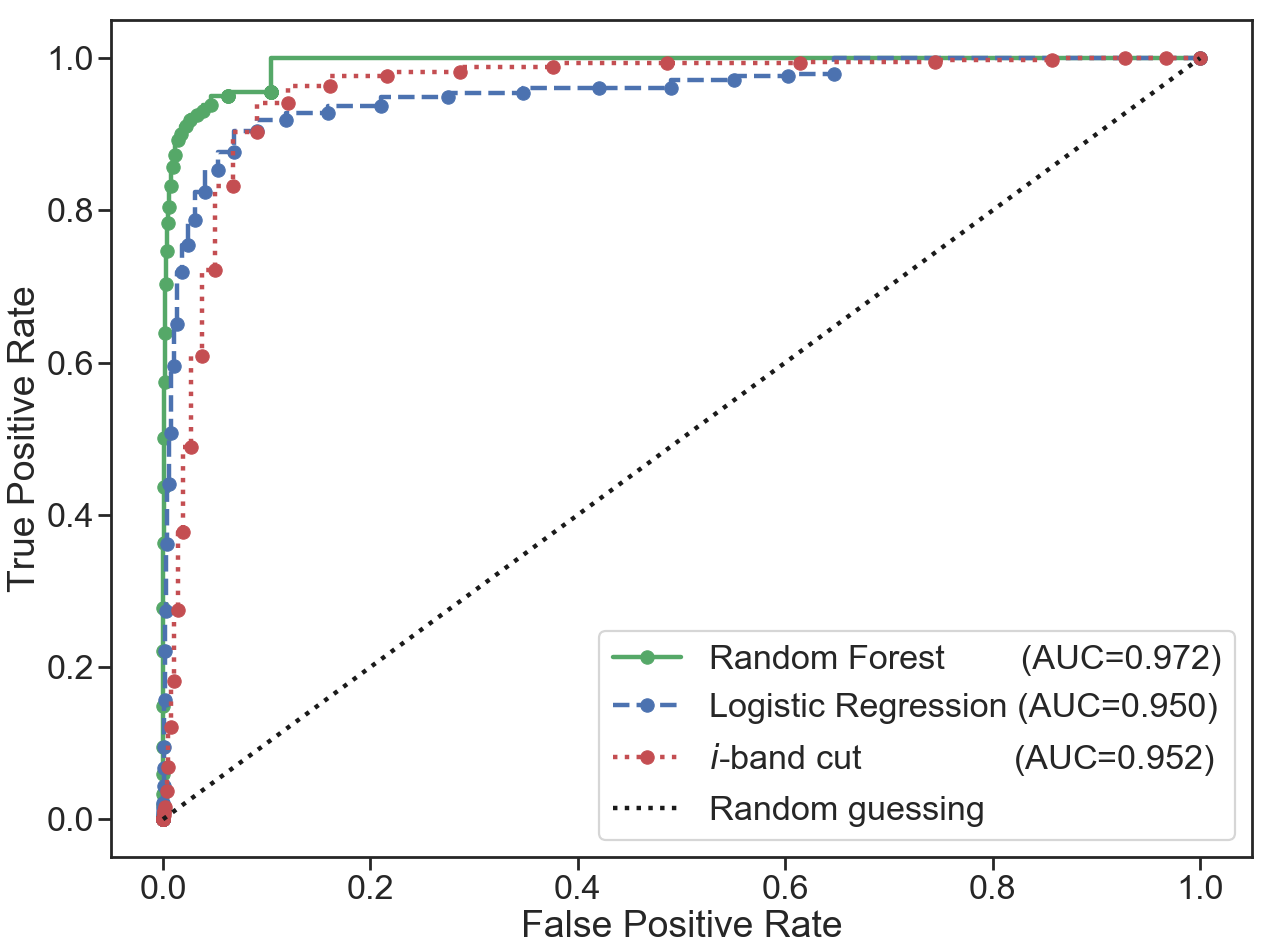

In [40]:
AUC_RF = sklearn.metrics.roc_auc_score(df_results.target, df_results.RF_prob)
plt.plot(FPR_RF, TPR_RF,
         marker="o", color=color_RF, label="Random Forest        (AUC={:.3f})".format(AUC_RF),
         drawstyle="steps-post",
         linewidth=linewidth,

)

AUC_LR = sklearn.metrics.roc_auc_score(df_results.target, df_results.LR_prob)
plt.plot(FPR_LR, TPR_LR,
         marker="o", color=color_LR, label="Logistic Regression (AUC={:.3f})".format(AUC_LR),
         linestyle="dashed",
         drawstyle="steps-post",
         linewidth=linewidth,

)
AUC_i_mag = sklearn.metrics.roc_auc_score(df_results.target, df_results.i_mag_prob)
plt.plot(FPR_i_mag, TPR_i_mag,
         marker="o", color=color_MC, label="$i$-band cut                (AUC={:.3f})".format(AUC_i_mag),
         linestyle="dotted",
         drawstyle="steps-post",
         linewidth=linewidth,

)

plt.plot([0,1], [0,1 ], linestyle="dotted", color="k", label="Random guessing",
         linewidth=linewidth,
        )


plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
# plt.xlim(0,1)
# plt.ylim(0,1)


plt.legend(loc="best")

filename = "plots_for_thesis/ROC-all"
plt.tight_layout()
plt.savefig(filename + ".pdf")
plt.savefig(filename + ".png")

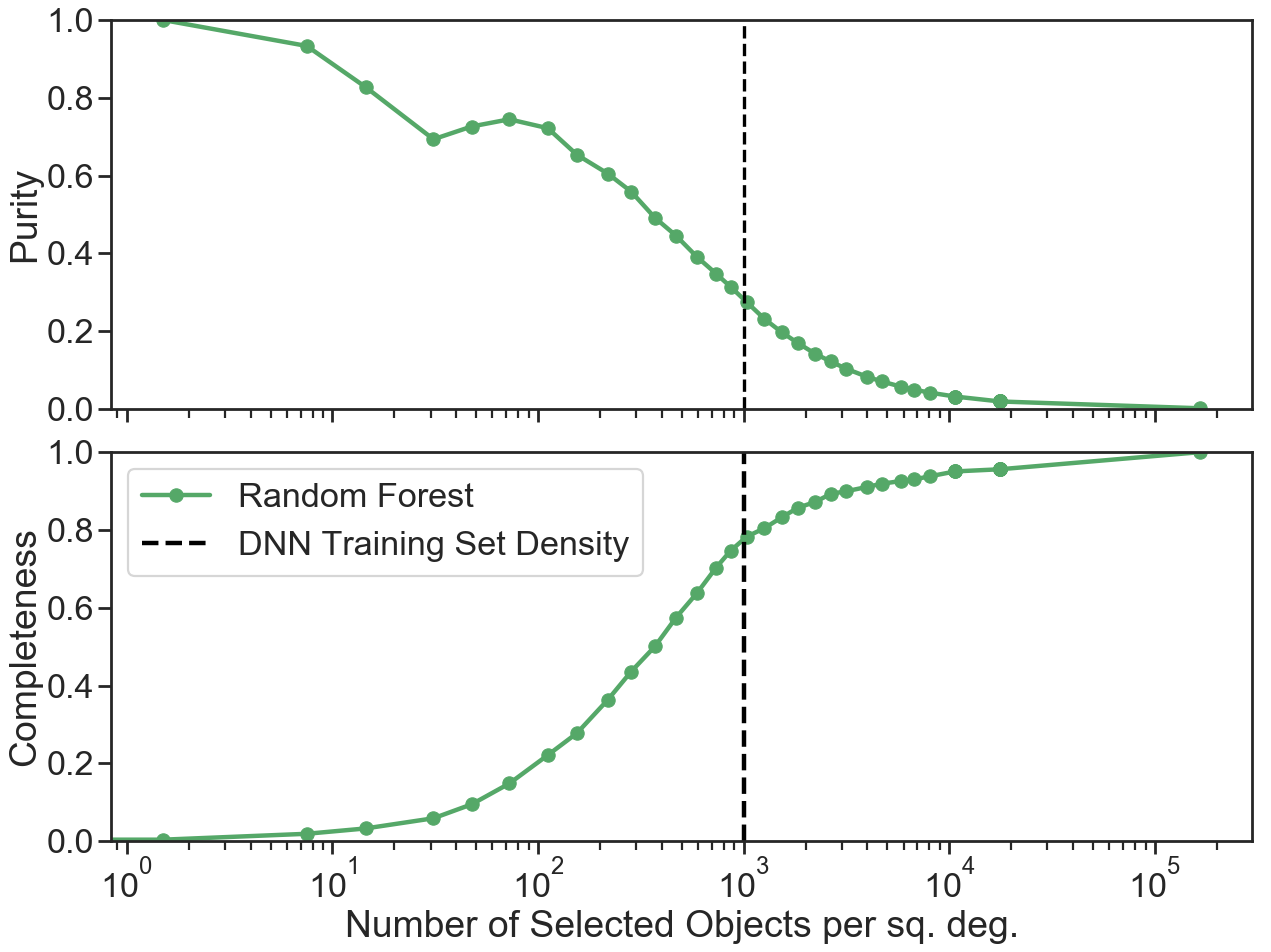

In [41]:
f, (ax1, ax2) = plt.subplots(2, sharex=True)
f.subplots_adjust(hspace=0.1)


ax1.plot(object_density_RF, purities_RF, 
         marker="o", color=color_RF, label=label_RF,
         linewidth=linewidth,
        )

ax1.axvline(1e3,
           color="black", linestyle="dashed", label="DNN Training Set Density")

ax1.set_ylabel("Purity")
ax1.set_xscale("log")
ax1.set_ylim(0,1)

ax2.plot(object_density_RF, completenesses_RF, 
         marker="o", color=color_RF, label=label_RF,
         linewidth=linewidth,
        )

ax2.axvline(1e3,
            color="black", linestyle="dashed", label="DNN Training Set Density",
            linewidth=linewidth,
           )

ax2.set_xlabel("Number of Selected Objects per sq. deg.")
ax2.set_ylabel("Completeness")
ax2.set_xscale("log")
ax2.set_ylim(0,1)

ax2.legend(loc="best")

plt.tight_layout()


filename = "plots_for_thesis/purity-completeness-RF"
plt.tight_layout()
plt.savefig(filename + ".pdf")
plt.savefig(filename + ".png")

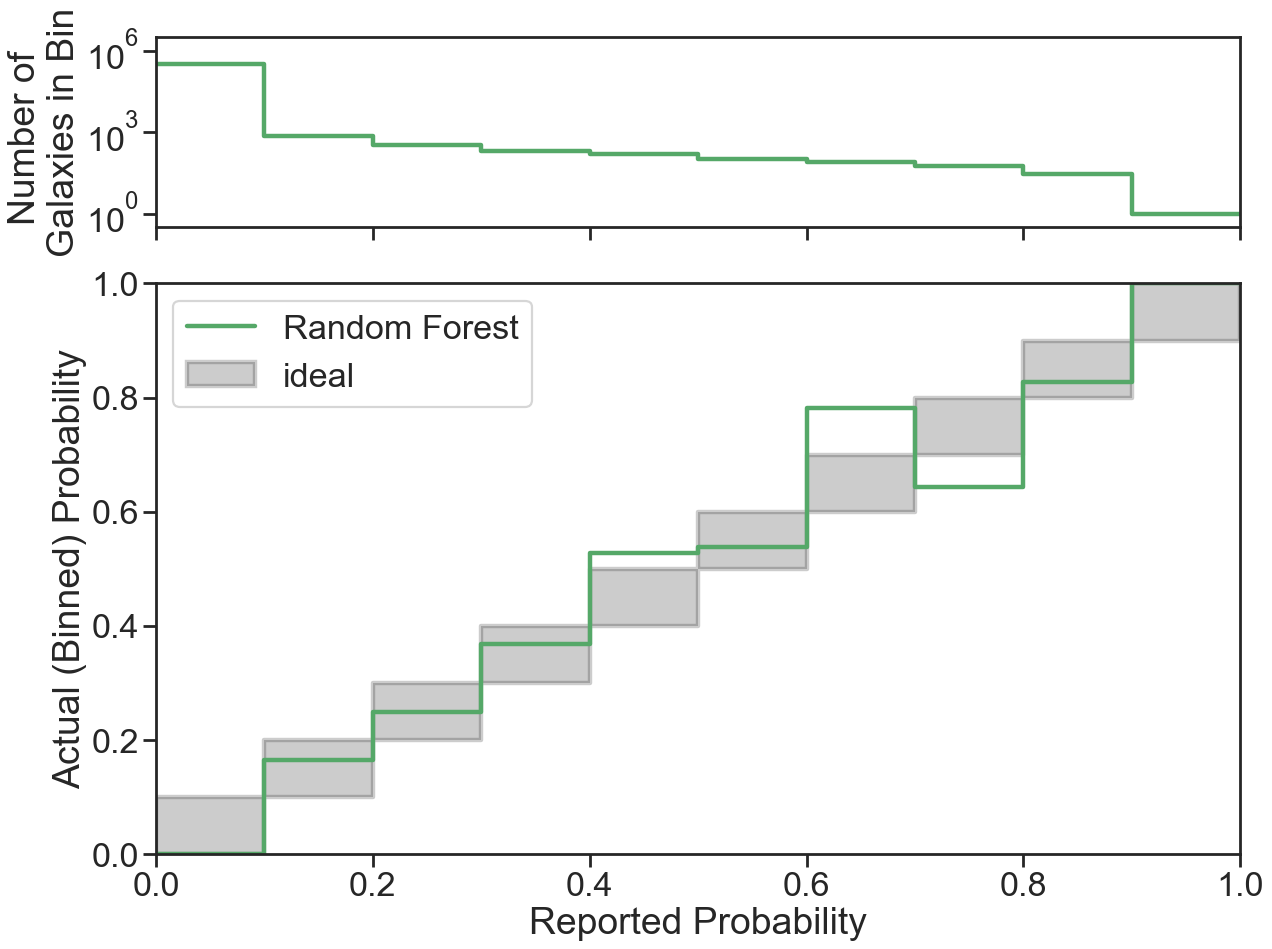

In [42]:
theoretical_probs=np.linspace(0,1,num=11)
empirical_probs_RF = np.empty(theoretical_probs.size-1)
num_in_bin_RF = np.empty_like(empirical_probs_RF)

for i in range(theoretical_probs.size-1):
    prob_lim_low  = theoretical_probs[i]
    prob_lim_high = theoretical_probs[i+1]
    
    mask_RF = (df_results["RF_prob"] >= prob_lim_low) & (df_results["RF_prob"] < prob_lim_high)
    empirical_probs_RF[i] = df_results["target"][mask_RF].mean()
    num_in_bin_RF[i] = df_results["target"][mask_RF].size

f, (ax1, ax2) = plt.subplots(2, sharex=True, 
                             gridspec_kw = {'height_ratios':[1, 3]},
                            )

ax1.plot(theoretical_probs, [num_in_bin_RF[0], *num_in_bin_RF],
         drawstyle="steps", color=color_RF,
         linewidth=linewidth,
        )

ax1.set_yscale("log")
ax1.set_ylim(bottom=10**-.5, top=10**6.5)
ax1.yaxis.set_ticks([1e0, 1e3, 1e6])
ax1.set_ylabel("Number of \nGalaxies in Bin")

ax2.step(theoretical_probs, [empirical_probs_RF[0], *empirical_probs_RF], 
         linestyle="steps", color=color_RF, label=label_RF,
         linewidth=linewidth,
        )

ax2.fill_between(theoretical_probs, theoretical_probs-theoretical_probs[1], theoretical_probs, 
                 step="pre", color="black", label="ideal", alpha=.2,
                 linewidth=linewidth,
                )

plt.xlabel("Reported Probability")
plt.ylabel("Actual (Binned) Probability")

plt.legend(loc="best")

plt.xlim(0,1)
plt.ylim(0,1)


plt.tight_layout()


filename = "plots_for_thesis/probability-calibration-RF"
plt.tight_layout()
plt.savefig(filename + ".pdf")
plt.savefig(filename + ".png")


In [43]:
sklearn.metrics.log_loss(df_results.target, df_results.RF_prob)

0.008584162549760178

In [44]:
n_trees = classifier_RF.n_estimators
n_pseudo_obs = 2
pseudo_obs_class_balance = 0.5
df_results["RF_prob_softened"] = (df_results["RF_prob"] * n_trees + n_pseudo_obs * pseudo_obs_class_balance) \
                                    / (n_trees + n_pseudo_obs)

sklearn.metrics.log_loss(df_results.target, df_results.RF_prob_softened)

0.006868875300331472

In [45]:
sklearn.metrics.log_loss(df_results.target, df_results.LR_prob)

0.009958606240087662

In [46]:
sklearn.metrics.log_loss(df_results.target, df_results.i_mag_prob)

0.011930754057327415

## Predicted Probabilities

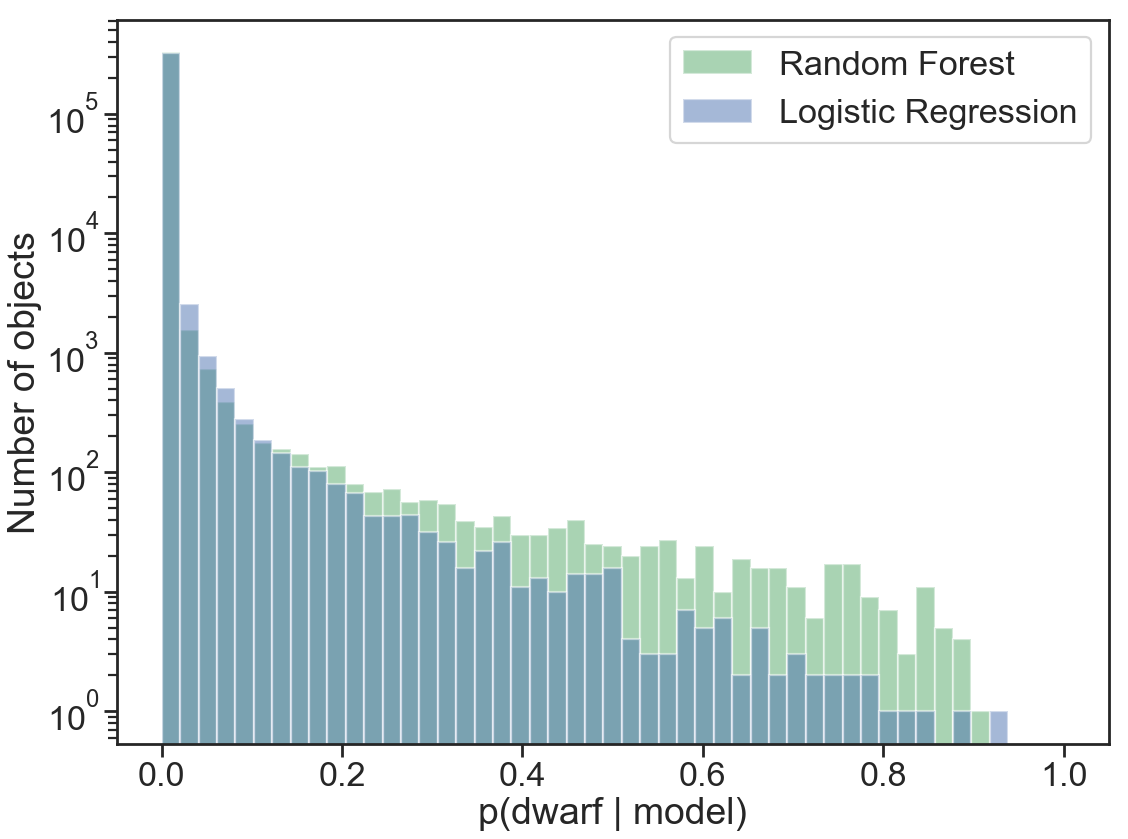

In [50]:
plt.hist(df_results["RF_prob"], bins=np.linspace(0,1), alpha=.5, color=color_RF, label=label_RF)
plt.hist(df_results["LR_prob"], bins=np.linspace(0,1), alpha=.5, color=color_LR, label=label_LR)

plt.yscale("log")
plt.xlabel("p(dwarf | model)")
plt.ylabel("Number of objects")

plt.legend(loc="best")

/Users/egentry/anaconda3/envs/tf36/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


Text(0, 0.5, 'CDF')

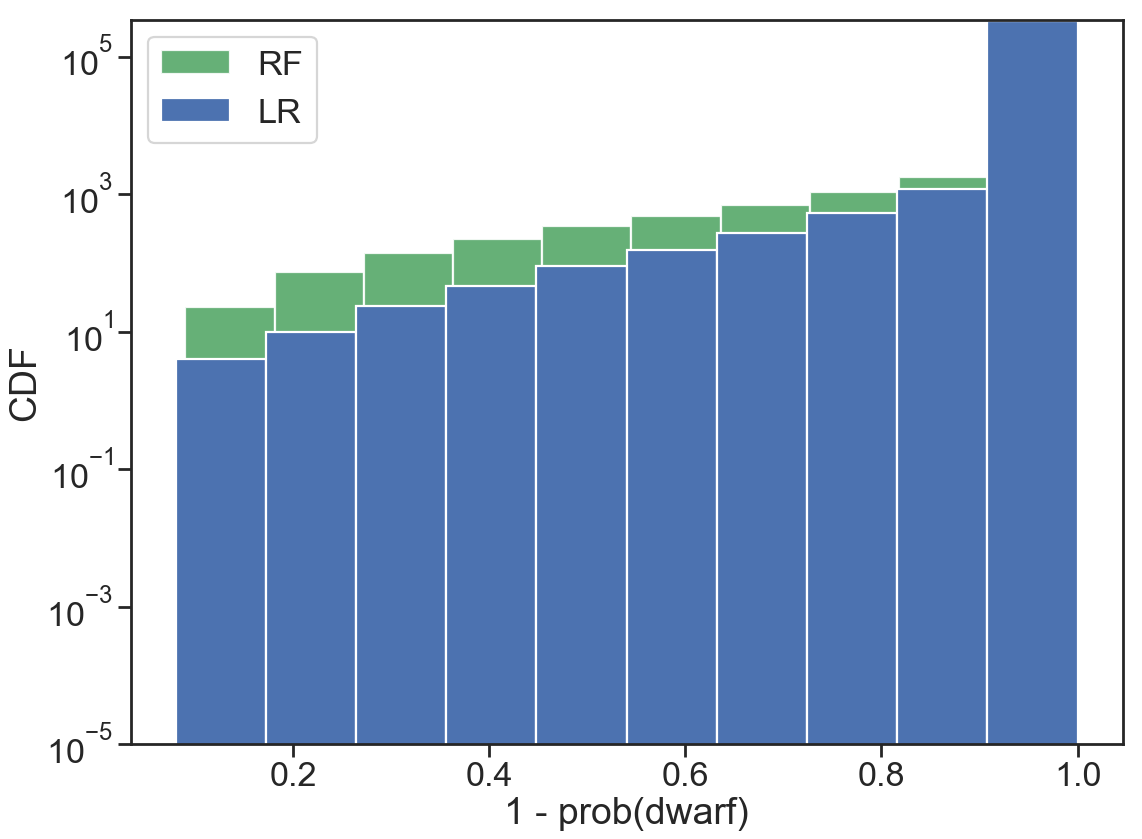

In [51]:
plt.hist(1-df_results["RF_prob"],
         cumulative=True, alpha=0.9,
         label="RF",
         color=color_RF)

plt.hist(1-df_results["LR_prob"],
         cumulative=True,
         label="LR",
         color=color_LR)

plt.ylim(ymin=1e-5)
plt.yscale("log")

plt.legend(loc="best")
plt.xlabel("1 - prob(dwarf)")
plt.ylabel("CDF")

# How do I actually get the images for the best candidate galaxies?
Check out `../data/get_training_galaxy_images.ipynb`